In [104]:
import os
import numpy as np
from scipy.stats import kde, binned_statistic
from matplotlib.ticker import FormatStrFormatter, MultipleLocator
import matplotlib.pyplot as plt

In [2]:
from astropy.io import fits
from astropy.table import Table

In [91]:
import seaborn as sns
sns.set(context='talk', style='ticks', font_scale=1.3)#, palette='Set1')

In [4]:
import legacyhalos.io

In [5]:
%matplotlib inline

In [6]:
def lambda2mhalo(richness, redshift=0.3, Saro=False):
    """
    Convert cluster richness, lambda, to halo mass, given various 
    calibrations.
    
      * Saro et al. 2015: Equation (7) and Table 2 gives M(500).
      * Melchior et al. 2017: Equation (51) and Table 4 gives M(200).
      * Simet et al. 2017: 
    
    Other SDSS-based calibrations: Li et al. 2016; Miyatake et al. 2016; 
    Farahi et al. 2016; Baxter et al. 2016.

    TODO: Return the variance!

    """
    if Saro:
        pass
    
    # Melchior et al. 2017 (default)
    logM0, Flam, Gz, lam0, z0 = 14.371, 1.12, 0.18, 30.0, 0.5
    Mhalo = 10**logM0 * (richness / lam0)**Flam * ( (1 + redshift) / (1 + z0) )**Gz
    
    return Mhalo

In [11]:
cat = legacyhalos.io.read_catalog(extname='LSPHOT-ISEDFIT', upenn=False, 
                                   isedfit=True, columns=('mstar_avg', 'sfr100_avg'))
cat1 = legacyhalos.io.read_catalog(extname='REDMAPPER', upenn=False, 
                                   isedfit=False, columns=('Z', 'LAMBDA_CHISQ'))
cat.add_columns_from(cat1)
cat

<tabledata object with 53441 rows and 4 columns: mstar_avg, sfr100_avg, z, lambda_chisq>

In [15]:
mhalo = np.log10(lambda2mhalo(cat.lambda_chisq, redshift=cat.z))
mhalo

array([ 15.18095684,  15.2603302 ,  14.94951439, ...,  13.64984703,
        13.81003761,  13.82654667], dtype=float32)

In [24]:
bins = 35

In [25]:
mstar_med, bin_edges, _ = binned_statistic(mhalo, cat.mstar_avg, statistic='median', bins=bins)
bin_width = (bin_edges[1] - bin_edges[0])
mhalo_med = bin_edges[1:] - bin_width/2
print(bin_width)

0.0509601593018


In [26]:
def p75(x):
    return np.percentile(x, 75)
def p25(x):
    return np.percentile(x, 25)

In [29]:
mstar_p25, _, _ = binned_statistic(mhalo, cat.mstar_avg, statistic=p25, bins=bins)
mstar_p75, _, _ = binned_statistic(mhalo, cat.mstar_avg, statistic=p75, bins=bins)

In [58]:
krav = dict()
krav['m500'] = np.log10(np.array([15.6,10.3,7,5.34,2.35,1.86,1.34,0.46,0.47])*1e14)
krav['mbcg'] = np.array([3.12,4.14,3.06,1.47,0.79,1.26,1.09,0.91,1.38])*1e12
krav['mbcg_err'] = np.array([0.36,0.3,0.3,0.13,0.05,0.11,0.06,0.05,0.14])*1e12
krav['mbcg_err'] = krav['mbcg_err'] / krav['mbcg'] / np.log(10)
krav['mbcg'] = np.log10(krav['mbcg'])

In [59]:
gonz = dict()
gonz['mbcg'] = np.array([0.84,0.87,0.33,0.57,0.85,0.60,0.86,0.93,0.71,0.81,0.70,0.57])*1e12*2.65
gonz['mbcg_err'] = np.array([0.03,0.09,0.01,0.01,0.14,0.03,0.03,0.05,0.07,0.12,0.02,0.01])*1e12*2.65
gonz['m500'] = np.array([2.26,5.15,0.95,3.46,3.59,0.99,0.95,3.23,2.26,2.41,2.37,1.45])*1e14
gonz['m500_err'] = np.array([0.19,0.42,0.1,0.32,0.28,0.11,0.1,0.19,0.23,0.18,0.24,0.21])*1e14
gonz['mbcg_err'] = gonz['mbcg_err'] / gonz['mbcg'] / np.log(10)
gonz['mbcg'] = np.log10(gonz['mbcg'])
gonz['m500'] = np.log10(gonz['m500'])

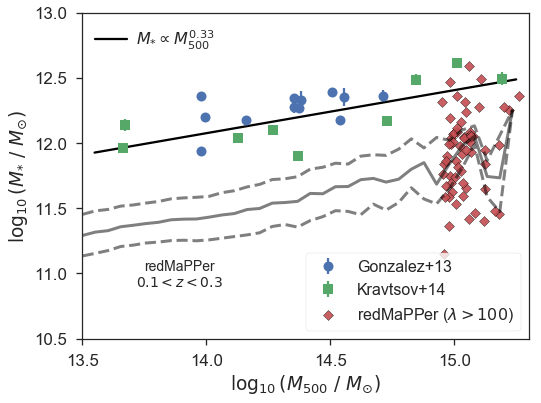

In [123]:
fig, ax = plt.subplots(figsize=(8, 6))

colors = iter(sns.color_palette())

rich = cat.lambda_chisq > 100
ax.plot(mhalo_med, mstar_med, color='k', ls='-', lw=3, alpha=0.5)
ax.plot(mhalo_med, mstar_p75, color='k', ls='--', lw=3, alpha=0.5)
ax.plot(mhalo_med, mstar_p25, color='k', ls='--', lw=3, alpha=0.5)

g = ax.errorbar(gonz['m500'], gonz['mbcg'], yerr=gonz['mbcg_err'], color=next(colors),
                fmt='o', label='Gonzalez+13', markersize=10)
k = ax.errorbar(krav['m500'], krav['mbcg'], yerr=krav['mbcg_err'], color=next(colors),
                fmt='s', label='Kravtsov+14', markersize=10)
r = ax.scatter(mhalo[rich], cat.mstar_avg[rich], alpha=0.9, color=next(colors),
               edgecolor='k', marker='D', s=50, label=r'redMaPPer ($\lambda>100$)')

ax.text(0.12, 0.16, 'redMaPPer\n$0.1<z<0.3$', multialignment='center',
        transform=ax.transAxes, fontsize=14)
m500 = np.linspace(13.55, 15.25, 50)
ff = ax.plot(m500, np.polyval([0.33, 12.24], m500-14.5), ls='-', 
            color='k', label=r'$M_{*}\propto M_{500}^{0.33}$')
ax.text(0.12, 0.9, r'$M_{*}\propto M_{500}^{0.33}$', multialignment='center',
        transform=ax.transAxes, fontsize=16)
ax.plot([13.55, 13.68], [12.8, 12.8], ls='-', color='k') # hack!!!

#ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.xaxis.set_major_locator(MultipleLocator(0.5))

hh = [g, k, r]
ax.legend(hh, [H.get_label() for H in hh], loc='lower right',
          frameon=True, fontsize=16)
#ax.legend(ff, ff.get_label(), loc='upper left',
#          frameon=True, fontsize=16)
#ax.legend(loc='upper left', frameon=True, fontsize=16)

ax.set_ylim(10.5, 13)
ax.set_xlim(13.5, 15.3)
ax.set_xlabel(r'$\log_{10}\, (M_{500}\ /\ M_{\odot})$')
ax.set_ylabel(r'$\log_{10}\, (M_{*}\ /\ M_{\odot})$')

In [116]:
ff

In [8]:
stop

NameError: name 'stop' is not defined

In [ ]:
cat

In [ ]:
legacyhalos_dir = os.getenv('LEGACYHALOS_DIR')

In [ ]:
parentfile = os.path.join(legacyhalos_dir, 'legacyhalos-parent-isedfit.fits')

In [ ]:
ls = Table(fits.getdata(parentfile, extname='LSPHOT-ISEDFIT'))
ls

In [ ]:
_ = plt.hist(ls['MSTAR_AVG'], bins=100)

In [ ]:
_ = plt.hist(sdss['MSTAR_AVG'], bins=100)

In [ ]:
_ = plt.hist(sdss['MSTAR_AVG'] - ls['MSTAR_AVG'], bins=200)
plt.xlim(-0.5, 0.5)

In [ ]:
sdss = Table(fits.getdata(parentfile, extname='SDSSPHOT-ISEDFIT'))
sdss

In [ ]:
data = np.vstack( (ls['MSTAR_AVG'], sdss['MSTAR_AVG'] - ls['MSTAR_AVG']))
data.shape

In [ ]:
k = kde.gaussian_kde(data.T)
#xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
#zi = k(np.vstack([xi.flatten(), yi.flatten()]))

In [ ]:
fig, ax = plt.subplots()
ax.hexbin(ls['MSTAR_AVG'], sdss['MSTAR_AVG'] - ls['MSTAR_AVG'],
          mincnt=1)

In [ ]:
sns.jointplot(ls['MSTAR_AVG'], sdss['MSTAR_AVG'] - ls['MSTAR_AVG'], 
              kind="kde", color="#4CB391", xlim=(10, 13), ylim=(-0.5, 0.5))

In [ ]:
sns.kdeplot(ls['MSTAR_AVG'], sdss['MSTAR_AVG'] - ls['MSTAR_AVG'], 
            cmap="Blues", shade=True, shade_lowest=True, cbar=True,
            cut=0,
           )

In [ ]:
help(sns.kdeplot)